In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
def create_dataset(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x = data[i:i + n_steps]
        seq_y = data[i + n_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

tickets = ["SBER"]#, "GAZP", "LKOH", "VTBR","ROSN", "NVTK", "CHMF"]

X, y = [], []
for ticket in tickets:

    data = pd.read_csv(ticket +".txt")
    prise = data["open"].tolist()
    value = data["value"].tolist()
    data = np.column_stack((prise, value)) 

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    x1, y1 = create_dataset(data, n_steps = 100)
    if len(X) == 0:
        X = x1
        y = y1
    else:
        X = np.concatenate((X, x1))
        y = np.concatenate((y, y1))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.005, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
print(X_train, y_train)
len(X_train)

tensor([[[9.4841e-01, 5.5439e-02],
         [9.4646e-01, 2.3006e-02],
         [9.4886e-01, 5.3809e-02],
         ...,
         [9.5013e-01, 7.4090e-03],
         [9.5046e-01, 8.6028e-03],
         [9.5209e-01, 9.0420e-03]],

        [[1.4824e-02, 3.1271e-02],
         [1.2215e-02, 1.5610e-02],
         [9.0424e-03, 5.5767e-02],
         ...,
         [3.8927e-02, 2.1947e-02],
         [3.9520e-02, 1.9769e-02],
         [3.8156e-02, 3.8193e-02]],

        [[2.6223e-01, 1.1647e-02],
         [2.6161e-01, 1.7581e-02],
         [2.6202e-01, 3.2181e-02],
         ...,
         [2.6890e-01, 1.5390e-03],
         [2.6943e-01, 9.2026e-04],
         [2.6929e-01, 2.7447e-03]],

        ...,

        [[2.9398e-01, 1.3347e-02],
         [2.9419e-01, 1.8034e-02],
         [2.9188e-01, 2.0696e-02],
         ...,
         [2.9134e-01, 1.8014e-02],
         [2.9013e-01, 1.7350e-02],
         [2.9042e-01, 7.4336e-03]],

        [[1.1180e-01, 6.0067e-02],
         [1.1346e-01, 3.0493e-02],
         [1.

32324

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # использование последнего выходного состояния
        return out


127.0
63.5
42.333333333333336
31.75
25.4
21.166666666666668
18.142857142857142
15.875
14.11111111111111
12.7
11.545454545454545
10.583333333333334
9.76923076923077
9.071428571428571
8.466666666666667
7.9375
7.470588235294118
7.055555555555555
6.684210526315789
6.35
6.0476190476190474
5.7727272727272725
5.521739130434782
5.291666666666667
5.08
4.884615384615385
4.703703703703703
4.535714285714286
4.379310344827586
4.233333333333333
4.096774193548387
3.96875
3.8484848484848486
3.735294117647059
3.6285714285714286
3.5277777777777777
3.4324324324324325
3.3421052631578947
3.2564102564102564
3.175
3.097560975609756
3.0238095238095237
2.953488372093023
2.8863636363636362
2.8222222222222224
2.760869565217391
2.702127659574468
2.6458333333333335
2.5918367346938775
2.54
2.4901960784313726
2.4423076923076925
2.3962264150943398
2.3518518518518516
2.309090909090909
2.267857142857143
2.2280701754385963
2.189655172413793
2.152542372881356
2.1166666666666667
2.081967213114754
2.0483870967741935
2.0158

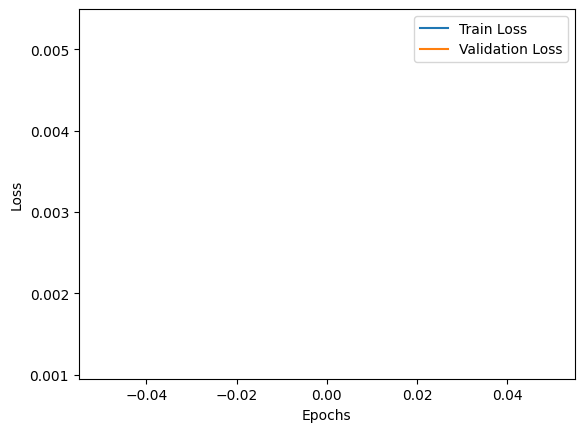

In [ ]:
# Гиперпараметры модели
input_size = 2  # размерность входного вектора (пара чисел)
hidden_size = 25  # размер скрытого состояния
output_size = 2  # размерность выходного вектора (пара чисел)
num_layers = 2  # количество слоев LSTM

model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, num_epochs, batch_size):
    train_losses = []
    val_losses = []
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    l = len(train_dataloader)

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        s = 0
        for batch_X, batch_y in train_dataloader:
            s += 1
            print(l / s)
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(train_loss)
        
        # Валидация
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val).item()
            val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        torch.cuda.empty_cache()


    return train_losses, val_losses

num_epochs = 1
# Обучение модели
train_losses, val_losses = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, num_epochs=num_epochs, batch_size=256)

plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
def create_dataset(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x = data[i:i + n_steps]
        seq_y = data[i + n_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Предсказание новой пары данных
model.eval()
data_test = pd.read_csv("LKOH.txt")
prise = data_test["open"].tolist()
value = data_test["value"].tolist()

data_test = np.column_stack((prise, value)) 
scaler = MinMaxScaler(feature_range=(0, 1))
data_test = scaler.fit_transform(data_test)
x_test, y_test = create_dataset(data_test, n_steps = 100)


with torch.no_grad():
    new_input = torch.tensor(x_test[0], dtype=torch.float32).unsqueeze(0)
    #new_input = x_test[0]  # используем последнюю последовательность для предсказания
    new_output = model(new_input)
    print("Predicted pair:", new_output.cpu().numpy(), "real pair:", y_test[0])
    #print("Predicted pair:", new_output.cpu().numpy() + " real pair " + y[1].cpu().numpy())


Predicted pair: [[0.03710288 0.03517596]] real pair: [0.03461503 0.00608509]


In [7]:
data = pd.read_csv("SBER_.txt")
p_min, p_max = min(data["open"].tolist()[-100:]), max(data["open"].tolist()[-100:])
v_min, v_max = min(data["value"].tolist()[-100:]), max(data["value"].tolist()[-100:])
print(p_min, p_max)
print(v_min, v_max)
print(0.81828237  * (p_max - p_min) + p_min)
print(0.02513959 * (v_max - v_min) + v_min)

313.8 329.17
5353050.0 3761757801.5000014
326.3770000269
99787525.32676192
